In [132]:
import os
import psycopg2
from dotenv import load_dotenv
from sshtunnel import SSHTunnelForwarder
import time
import pandas as pd
import numpy as np
import statsmodels
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [10]:
# Load environment variables from .env file
load_dotenv("environment_variables.env")
psql_pw = os.getenv("PSQL_PW")

# Get data
## DB Connection

In [11]:
# Connect to AWS RDS instance through AWS EC2 instance

# SSH parameters
bastion_host = 'ec2-34-224-93-62.compute-1.amazonaws.com'
bastion_user = 'ec2-user'
# bastion_key = 'C:\\Users\\detto\\Documents\\ec2-key-pair.pem'
bastion_key = "/Users/adettor/Documents/YouTubeViewPrediction/ec2-key-pair.pem"

# RDS parameters
rds_host = 'youtubeviewprediction.cd0c8oow2pnr.us-east-1.rds.amazonaws.com'
rds_user = 'postgres'
rds_password = psql_pw
rds_database = 'YouTubeViewPrediction'
rds_port = 5432

try:
    # Create an SSH tunnel
    tunnel = SSHTunnelForwarder(
        (bastion_host, 22),
        ssh_username=bastion_user,
        ssh_pkey=bastion_key,
        remote_bind_address=(rds_host, rds_port),
        local_bind_address=('localhost', 6543)  # Choose a local port for the tunnel
    )

    # Start the tunnel
    tunnel.start()

    # Connect to PostgreSQL through the tunnel
    conn = psycopg2.connect(
        database=rds_database,
        user=rds_user,
        password=rds_password,
        host=tunnel.local_bind_host,
        port=tunnel.local_bind_port
    )

    # Create a cursor object
    cursor = conn.cursor()

    # Execute a SQL query
    cursor.execute("SELECT version();")

    # Fetch result
    record = cursor.fetchone()
    print("You are connected to - ", record)

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL:", error)

You are connected to -  ('PostgreSQL 16.1 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 7.3.1 20180712 (Red Hat 7.3.1-12), 64-bit',)


## Turn SQL tables in to Pandas dataframes

In [12]:
video_fact = pd.read_sql_query("SELECT * FROM video_fact", conn)
video_dim = pd.read_sql_query("SELECT * FROM video_dim", conn)
channel_fact = pd.read_sql_query("SELECT * FROM channel_fact", conn)
channel_dim = pd.read_sql_query("SELECT * FROM channel_dim", conn)
categories_dim = pd.read_sql_query("SELECT * FROM categories_dim", conn)

In [13]:
conn.close()
cursor.close()
tunnel.stop()

# EDA
## video_fact

In [14]:
video_fact.shape

(69552, 5)

In [15]:
video_fact.dtypes

collected_at    datetime64[ns]
video_id                object
num_views                int64
num_likes                int64
num_comments             int64
dtype: object

In [16]:
video_fact.describe()

,collected_at,num_views,num_likes,num_comments
count,69552,6.955200e+04,6.955200e+04,69552.000000
mean,2024-07-31 11:44:47.707151872,2.966156e+06,1.161449e+05,7713.911189
min,2024-07-20 21:00:06.211863,3.034000e+04,0.000000e+00,0.000000
25%,2024-07-27 18:00:05.890169088,4.795745e+05,1.304050e+04,988.000000
50%,2024-08-01 03:00:05.274309888,9.695195e+05,3.165850e+04,2436.000000
75%,2024-08-04 15:00:05.219883008,2.072256e+06,7.722900e+04,4984.000000
max,2024-08-07 15:00:05.985525,2.175802e+08,8.302094e+06,385935.000000
std,NaN,1.152891e+07,5.303614e+05,29650.997935


Some videos have 0 likes and/or 0 comments

In [17]:
video_fact[["collected_at", "video_id"]].nunique()

collected_at    143
video_id        765
dtype: int64

In [18]:
video_fact.isna().sum()

collected_at    0
video_id        0
num_views       0
num_likes       0
num_comments    0
dtype: int64

### video_id

In [19]:
id_counts = video_fact["video_id"].value_counts()
id_counts

video_id
laNA2HgwYXU    143
uhbDfi7Ee7k    143
30ybT5NQ9pg    143
GHtIxjKPP9w    143
j7YgKocz2W4    143
              ... 
brOSi_rpGj4      1
hVP07Qm3i78      1
JRF_sdTXpGw      1
ru6xSH1RaPw      1
rl9Ioumnb_Y      1
Name: count, Length: 765, dtype: int64

Text(0, 0.5, 'Number of Time Points Collected')

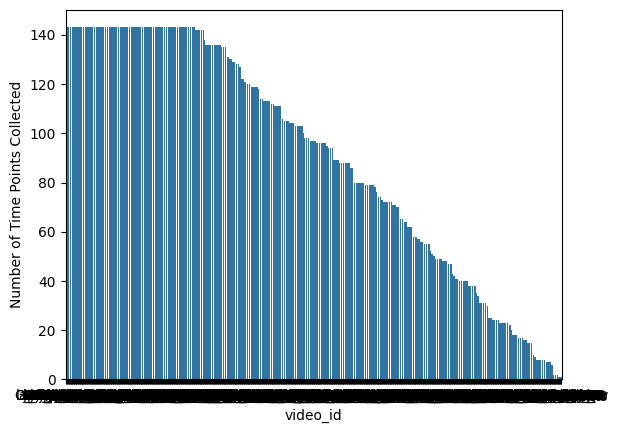

In [20]:
ax = sns.barplot(x=id_counts.index, y=id_counts)
ax.set_ylabel("Number of Time Points Collected")

In [21]:
id_counts2 = id_counts.value_counts()
id_counts2.sort_index(inplace=True, ascending=False)
id_counts2

count
143    200
142     13
140      1
138      1
136     24
      ... 
8       14
7        8
6        4
2        8
1        5
Name: count, Length: 89, dtype: int64

Text(0, 0.5, 'Number of Videos')

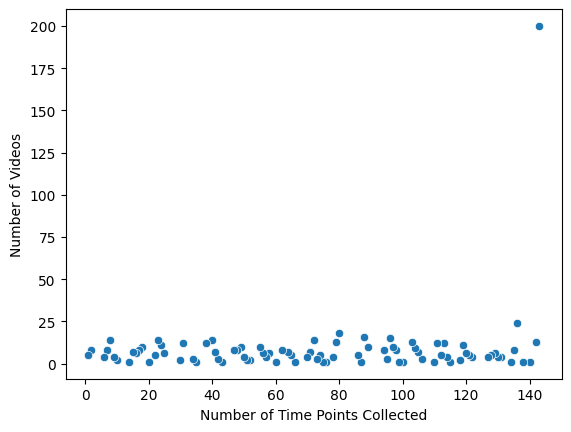

In [22]:
ax = sns.scatterplot(x=id_counts2.index, y=id_counts2)
ax.set_xlabel("Number of Time Points Collected")
ax.set_ylabel("Number of Videos")

In [27]:
ids = id_counts.sample(15).index
print(ids)

Index(['2XWjcHd-Nc0', '0ZsjxKJuGiY', 'IjBjm6vm2D0', 'kxtcsw7RxOc',
       'E6Sfs1dbn38', 'F6-NATMVXZI', '4SNThp0YiU4', 'w3HZ3ior4_s',
       'RfNy0RcnTKY', 'ytbjsKCGRGg', 'zlr9XnURJx4', '9LUExu3qU-o',
       'Xn-AwNDWLZ0', 'yD9Xo0V-hPw', 'Z5P0F5aBUz8'],
      dtype='object', name='video_id')


### num_views

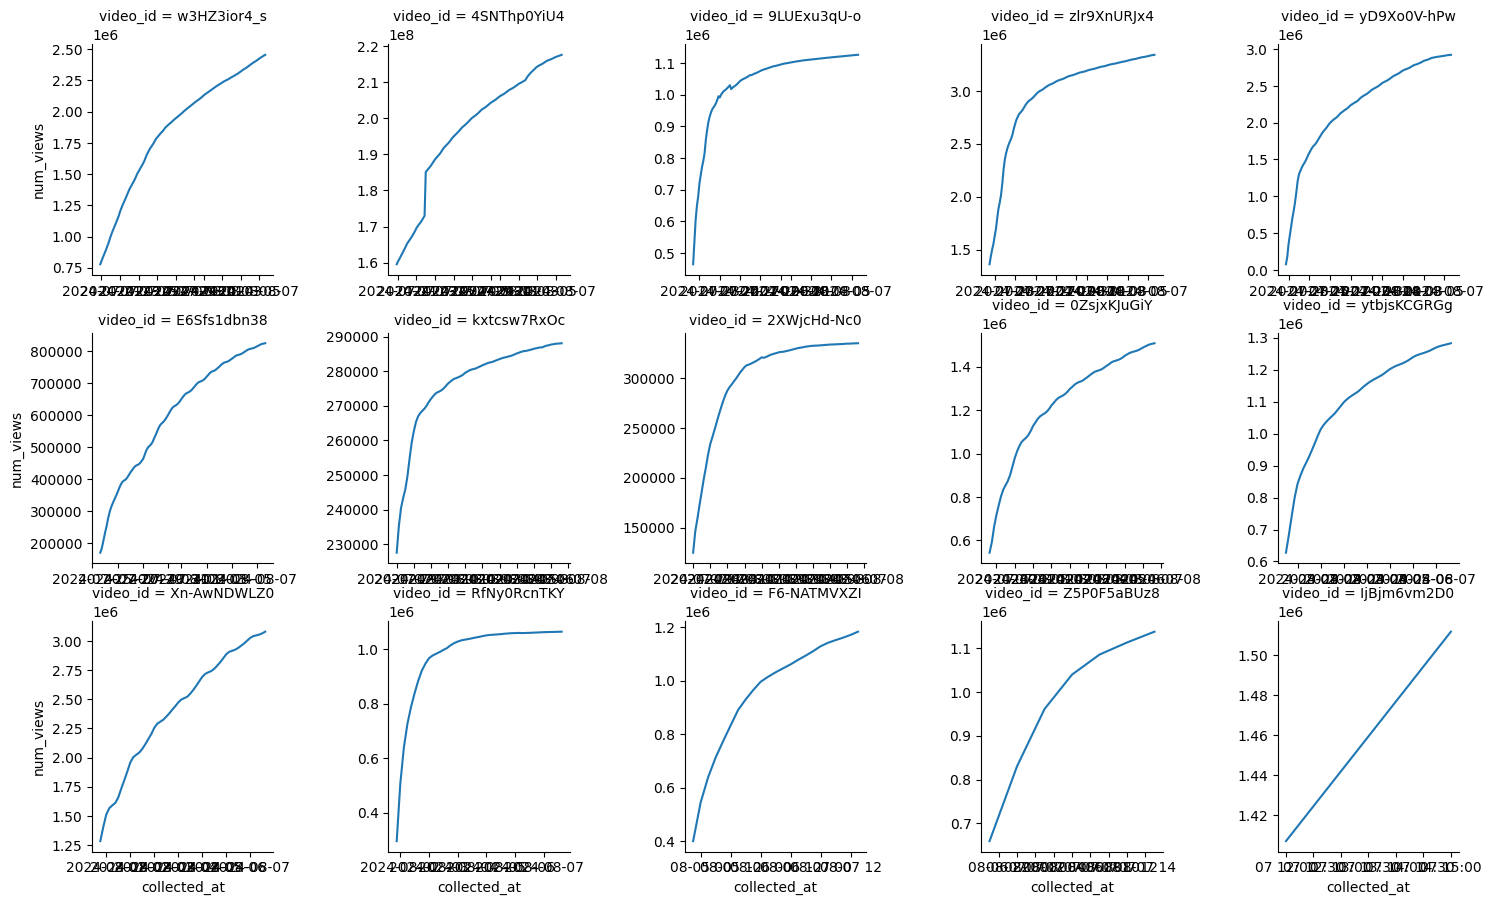

In [28]:
col = "num_views"
id_data = video_fact.loc[video_fact["video_id"].isin(ids), ["video_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="video_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

### num_comments

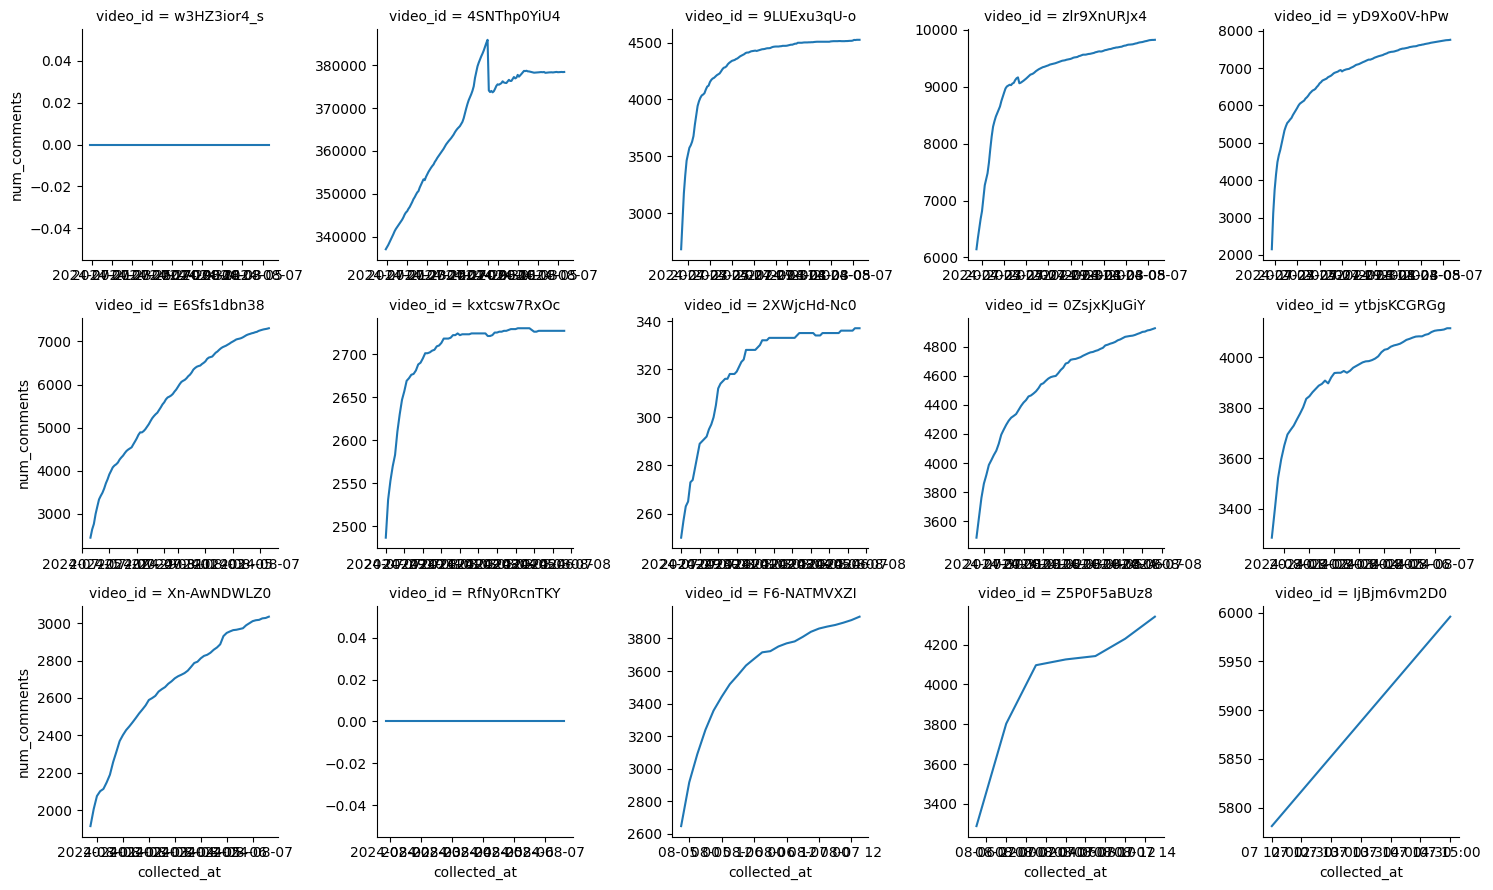

In [30]:
col = "num_comments"
id_data = video_fact.loc[video_fact["video_id"].isin(ids), ["video_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="video_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

### num_likes

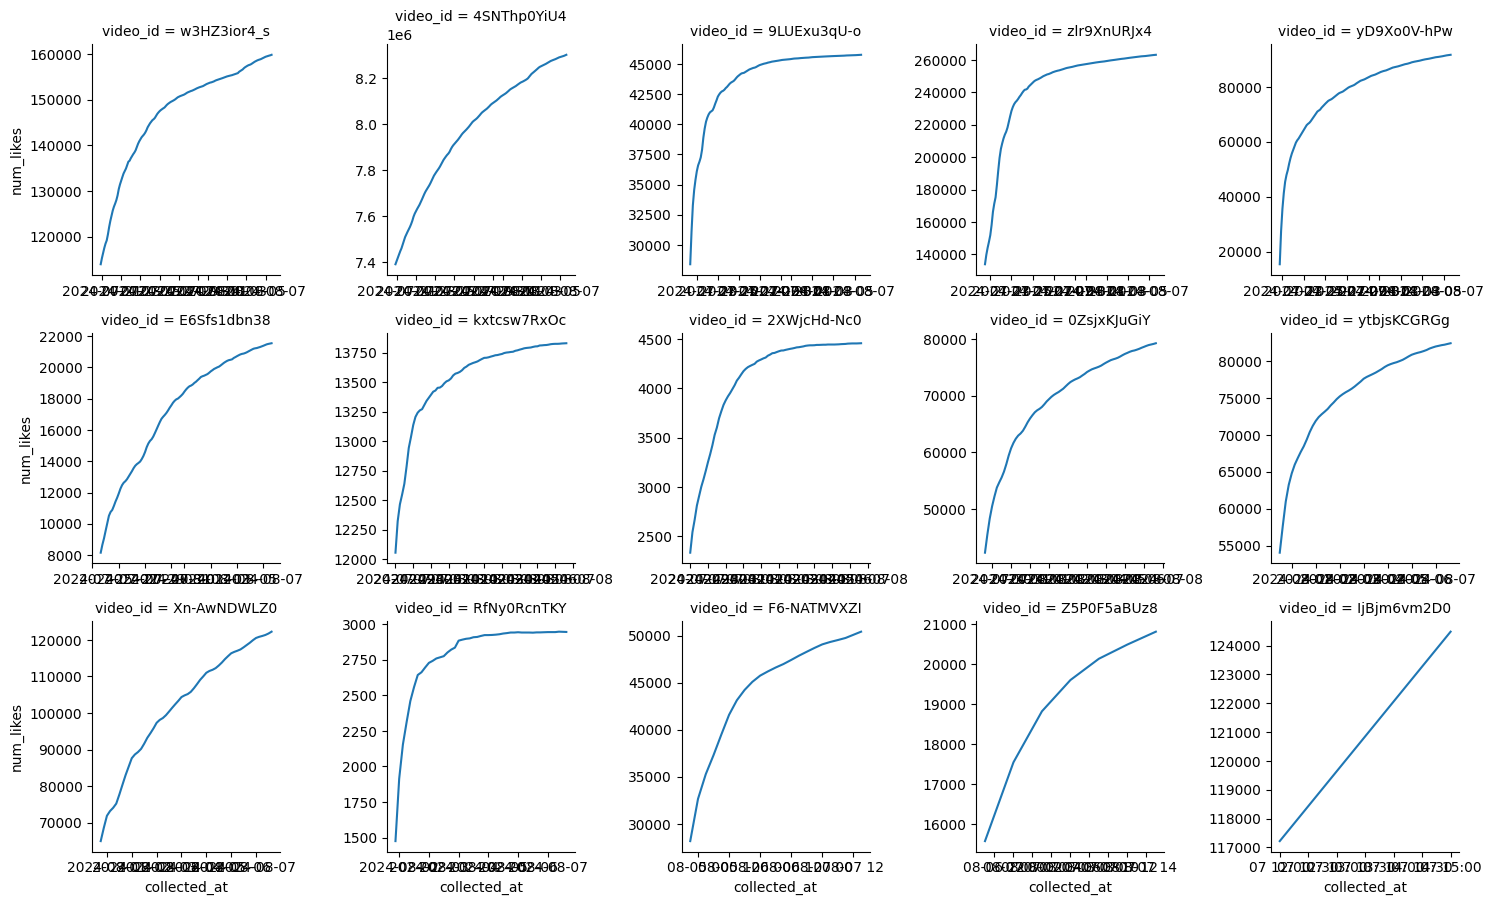

In [31]:
col = "num_likes"
id_data = video_fact.loc[video_fact["video_id"].isin(ids), ["video_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="video_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

## channel_fact

In [32]:
channel_fact.shape

(57064, 5)

In [33]:
channel_fact.dtypes

collected_at           datetime64[ns]
channel_id                     object
channel_total_views             int64
num_subscribers                 int64
num_videos                      int64
dtype: object

In [34]:
channel_fact.describe()

,collected_at,channel_total_views,num_subscribers,num_videos
count,57064,5.706400e+04,5.706400e+04,57064.000000
mean,2024-07-31 06:15:25.144969984,2.386325e+09,6.011196e+06,6441.882308
min,2024-07-20 21:00:07.479465,0.000000e+00,1.670000e+02,1.000000
25%,2024-07-27 12:00:07.836751104,1.684962e+08,6.500000e+05,216.000000
50%,2024-07-31 21:00:07.914458112,6.296084e+08,1.920000e+06,666.000000
75%,2024-08-04 12:00:08.725175040,1.850096e+09,5.430000e+06,2528.000000
max,2024-08-07 15:00:09.169222,8.677596e+10,3.080000e+08,295000.000000
std,NaN,5.730550e+09,1.786824e+07,22941.049896


Some channels have total views hidden. At least one channel has 1 video?!

In [35]:
channel_fact[["collected_at", "channel_id"]].nunique()

collected_at    143
channel_id      581
dtype: int64

In [36]:
channel_fact.isna().sum()

collected_at           0
channel_id             0
channel_total_views    0
num_subscribers        0
num_videos             0
dtype: int64

### channel_id

In [37]:
id_counts = channel_fact["channel_id"].value_counts()
id_counts

channel_id
UC2OREBiIbDChxvmDeg30Bsg    143
UC5sGdW8Jf7ijogDhcIFRmlw    143
UC7ABaoK3AFxuy_i4f6xV1tA    143
UCY6Ij8zOds0WJEeqCLOnqOQ    143
UCJbYdyufHR-cxOuY96KIoqA    143
                           ... 
UCpOXWy4Erc4UNoxI9xW-CXw      2
UCTSRIY3GLFYIpkR2QwyeklA      2
UCMOqf8ab-42UUQIdVoKwjlQ      2
UCqNsFioLEaG2NQpYGvidLPg      1
UCIZP6nCTyU9VV0zIhY7q1Aw      1
Name: count, Length: 581, dtype: int64

Text(0, 0.5, 'Number of Time Points Collected')

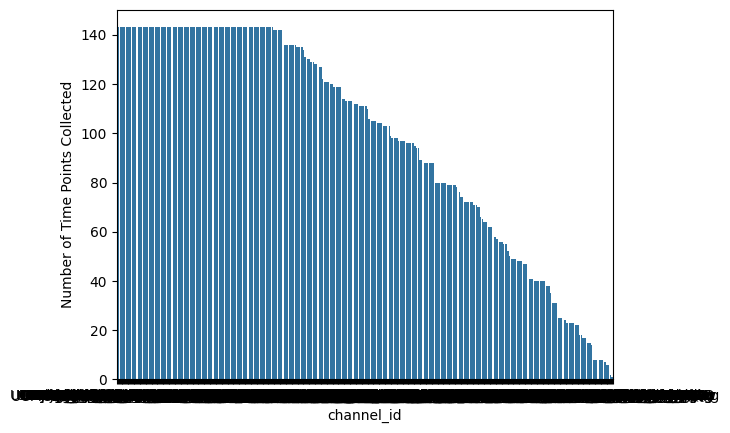

In [38]:
ax = sns.barplot(x=id_counts.index, y=id_counts)
ax.set_ylabel("Number of Time Points Collected")

In [39]:
id_counts2 = id_counts.value_counts()
id_counts2.sort_index(inplace=True, ascending=False)
id_counts2

count
143    183
142     11
136     16
135      8
134      1
      ... 
8       11
7        4
6        3
2        3
1        2
Name: count, Length: 79, dtype: int64

Text(0, 0.5, 'Number of Videos')

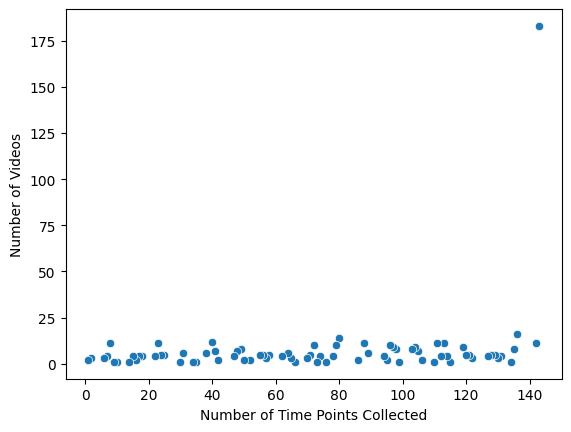

In [40]:
ax = sns.scatterplot(x=id_counts2.index, y=id_counts2)
ax.set_xlabel("Number of Time Points Collected")
ax.set_ylabel("Number of Videos")

In [41]:
ids = id_counts.sample(15).index
print(ids)

Index(['UCNzszbnvQeFzObW0ghk0Ckw', 'UCsvn_Po0SmunchJYOWpOxMg',
       'UC_Av98lDjf5KvFib5elhpYg', 'UCmGSJVG3mCRXVOP4yZrU1Dw',
       'UCWJ2lWNubArHWmf3FIHbfcQ', 'UCP-Ng5SXUEt0VE-TXqRdL6g',
       'UC7v3-2K1N84V67IF-WTRG-Q', 'UCSVpCNZzOeMekuMiFze3fnQ',
       'UCRE2zmVNW9wG2dndMoV4JKQ', 'UC3jFoA7_6BTV90hsRSVHoaw',
       'UCt7fwAhXDy3oNFTAzF2o8Pw', 'UC5Qbo0AR3CwpmEq751BIy0g',
       'UCBvlfsQ1UBWLn2te8sJbobA', 'UCzrM_068Odho89mTRrrxqbA',
       'UCAOiVaJJlH0Oduv48NN0mMA'],
      dtype='object', name='channel_id')


### channel_total_views

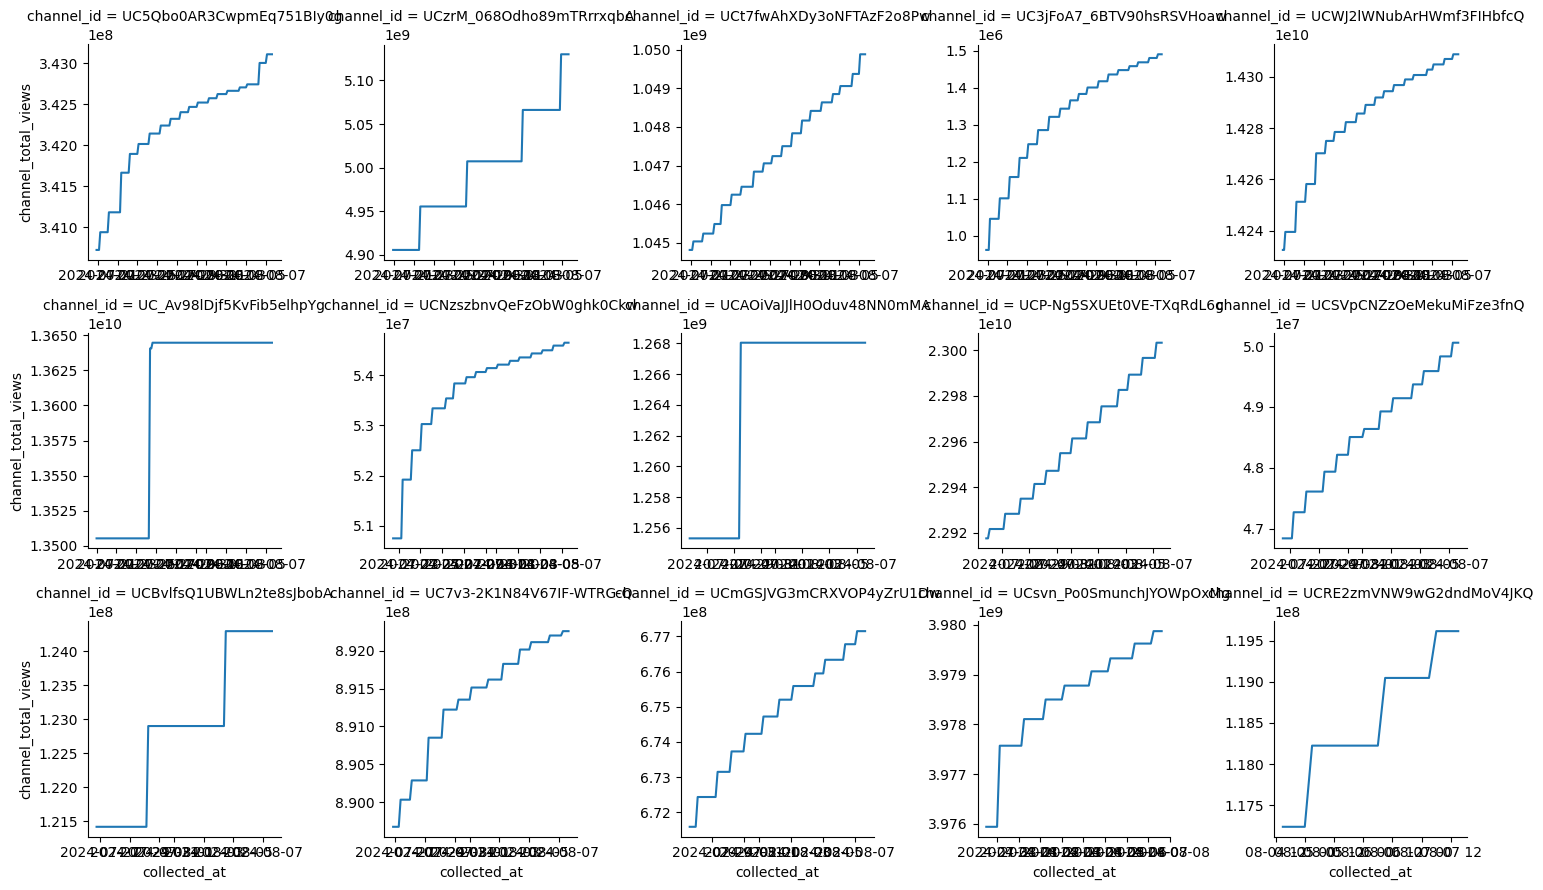

In [42]:
col = "channel_total_views"
id_data = channel_fact.loc[channel_fact["channel_id"].isin(ids), ["channel_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="channel_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

### num_subscribers

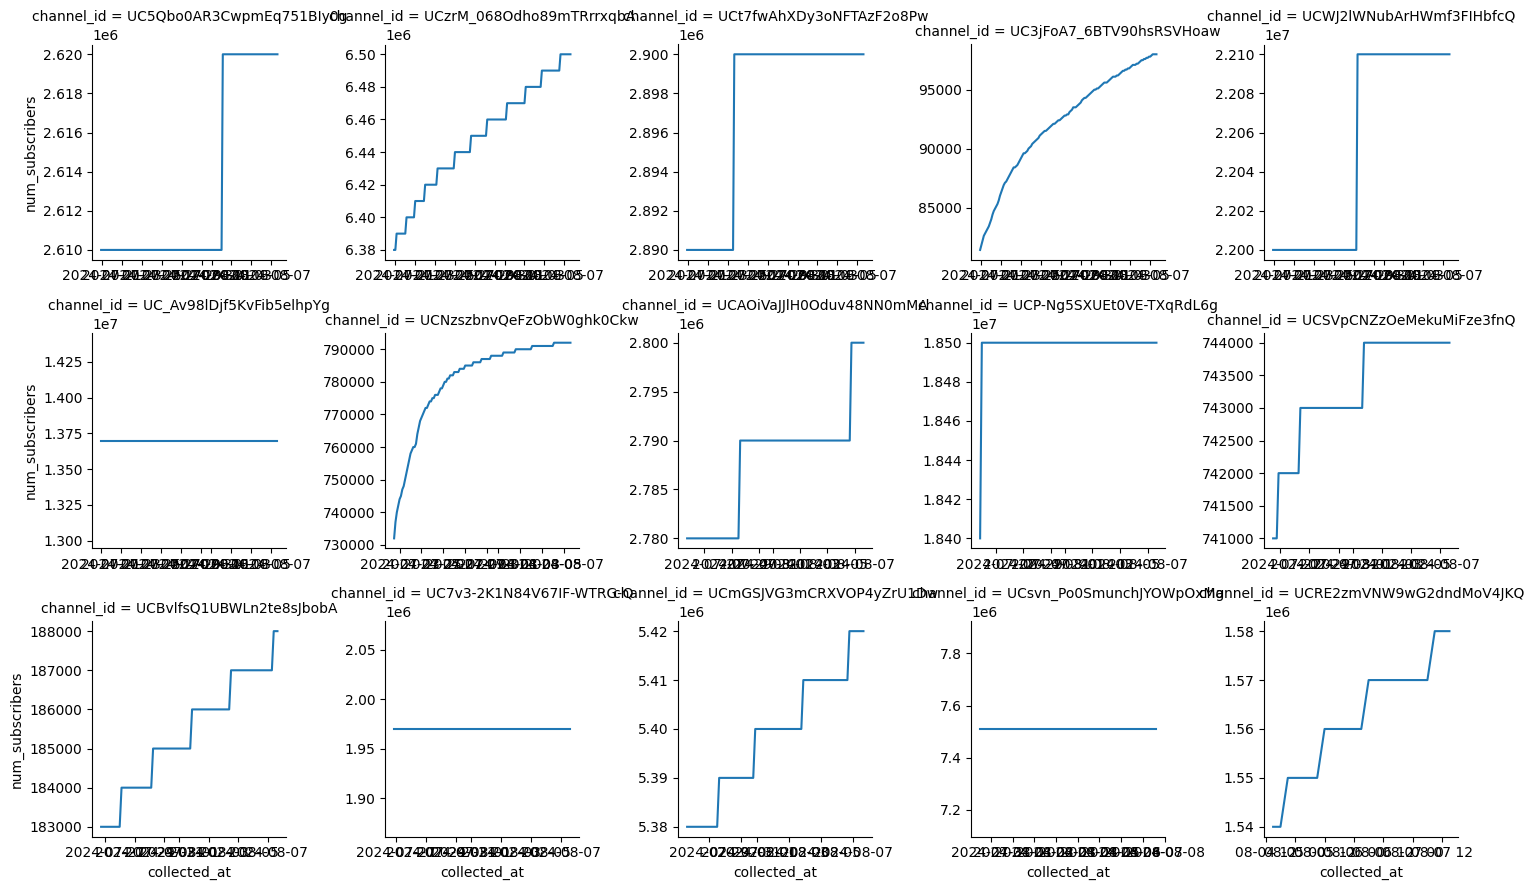

In [43]:
col = "num_subscribers"
id_data = channel_fact.loc[channel_fact["channel_id"].isin(ids), ["channel_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="channel_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

### num_videos

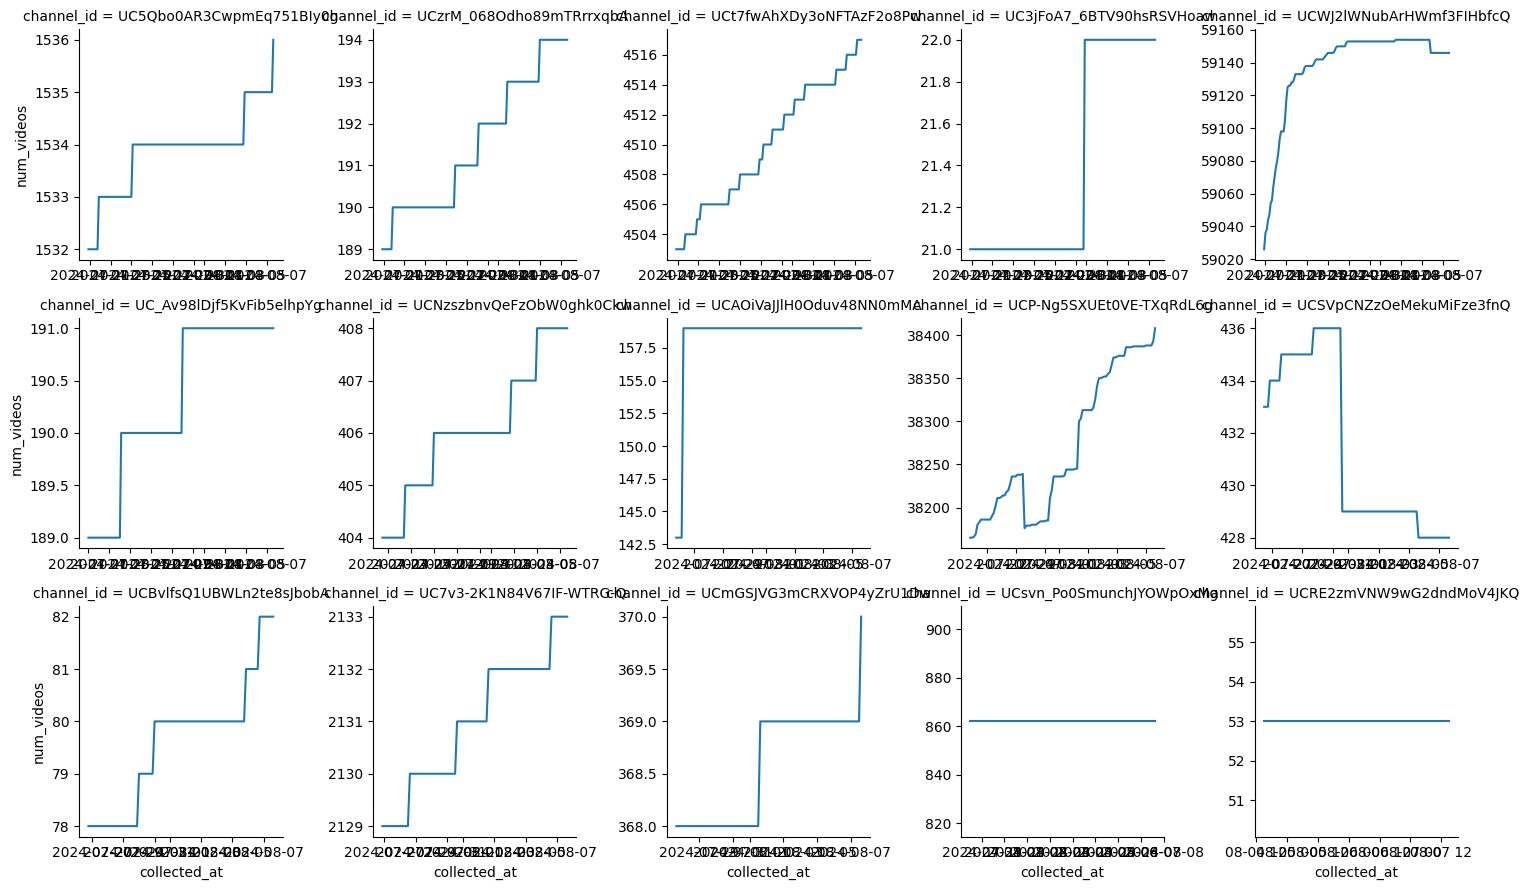

In [44]:
col = "num_videos"
id_data = channel_fact.loc[channel_fact["channel_id"].isin(ids), ["channel_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="channel_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

## video_dim

In [54]:
video_dim.shape

(765, 10)

In [55]:
video_dim.dtypes

video_id                     object
channel_id                   object
video_title                  object
video_description            object
num_tags                      int64
duration_seconds              int64
licensed_content               bool
made_for_kids                  bool
published_at         datetime64[ns]
category_id                   int64
dtype: object

In [56]:
video_dim.describe()

,num_tags,duration_seconds,published_at,category_id
count,765.000000,765.000000,765,765.000000
mean,16.030065,963.409150,2024-07-25 16:47:18.958170112,18.564706
min,0.000000,22.000000,2024-06-26 12:22:40,1.000000
25%,4.000000,203.000000,2024-07-19 15:28:04,17.000000
50%,15.000000,635.000000,2024-07-25 21:00:07,20.000000
75%,25.000000,1406.000000,2024-07-31 17:00:24,24.000000
max,64.000000,13311.000000,2024-08-07 02:21:24,28.000000
std,13.076012,1045.677287,NaN,6.555647


### video_id

In [57]:
video_dim["video_id"].sample(15)

741    OFWSHjWzRa0
83     x3whjqfQGYk
192    uQ8yDdtoFj0
722    dP0kFJEZSio
450    RVgmfyEfIW4
529    1KpHSCPyZzE
457    VIbidJm9q34
559    1eafBVGTJQ8
59     VV1nlMBEM0Y
139    uhbDfi7Ee7k
458    ea-_YCslAqU
625    6w97dXvadgs
633    tF0bky6sDBc
465    BnF2ziGuuu4
403    S7J-rv_OD1g
Name: video_id, dtype: object

In [58]:
video_dim["video_id"].apply(lambda x: len(x)).value_counts()

video_id
11    765
Name: count, dtype: int64

### video_title

In [59]:
video_dim["video_title"].sample(15)

402            Bridgerton FINALLY made me CRY (season 3)
364                  The Amazing Digital Circus But smol
292    Fortnite’s *NEW* GIANT Update! (FREE Cybertruc...
120       Ranking Every Potato Chip | Ranked With Babish
108    HEARTS 1-5 TOTTENHAM HOTSPUR | PRE-SEASON HIGH...
655    Roman Reigns rocks the WWE Universe with Summe...
277    Jimin: Who | The Tonight Show Starring Jimmy F...
686    The Hermitcraft SHOP PURGE!  -   Hermitcraft  ...
158                    '이게 맞아?!' Announcement (from USA)
245          Razer's new keyboard is basically cheating.
747                       Hunters vs VENOM in Minecraft!
176           President Biden Addresses the Nation (ASL)
468    Christians worldwide denounce Last Supper ‘bla...
491    EXTREME KITCHEN RENOVATION EP 9 | Appliances, ...
703    Monster Hunter Wilds: Great Sword | Weapon Ove...
Name: video_title, dtype: object

In [60]:
video_dim["video_title"].apply(lambda x: len(x)).value_counts()

video_title
49    27
43    22
42    21
58    18
59    17
      ..
21     2
86     1
4      1
7      1
88     1
Name: count, Length: 93, dtype: int64

### video_description

In [61]:
video_dim["video_description"].sample(15)

31     Provided to YouTube by JYP Entertainment Corpo...
311    Jake Paul trains with the USA boxing team in C...
707    USA TOUR TICKETS HERE\n► https://shop.kurtisco...
423    Well, well, it's about that time for THE BOYS ...
29     Watch live tonight, the stream starts at 6pm! ...
233    I played Pokemon Sword using only in-game trad...
234    ►Buy the Sanguine Samurai Displate https://dis...
230    Watch the best shots and moments from the thir...
451    We can't believe this actually happened, like ...
550    Baby Darlington,\nyou are already so deeply lo...
219    Check your Fortnite stats. Did you get any eli...
711    Get 50% off your first order of Sundays: https...
59     A major IT outage related to cybersecurity sof...
192    Joshua Tree has the most unique airbnbs!! For ...
392    https://www.eezyball.com - FOR TICKETS!!\n\n\n...
Name: video_description, dtype: object

In [62]:
video_dim["video_description"].apply(lambda x: len(x)).value_counts()

video_description
555     4
0       4
497     4
485     4
304     3
       ..
2046    1
2067    1
1454    1
668     1
1106    1
Name: count, Length: 641, dtype: int64

### num_tags

<Axes: xlabel='num_tags', ylabel='Count'>

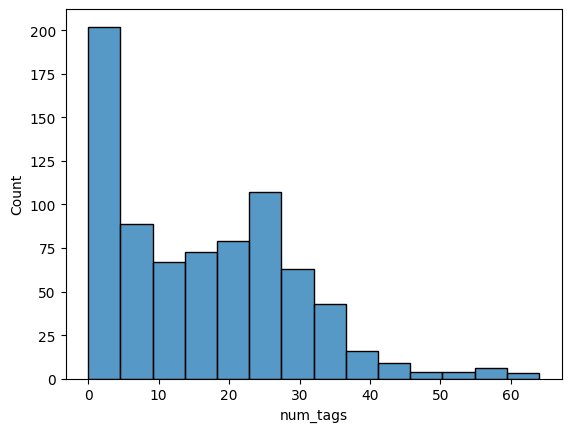

In [63]:
sns.histplot(video_dim, x="num_tags")

### duration_seconds

<Axes: xlabel='duration_seconds', ylabel='Count'>

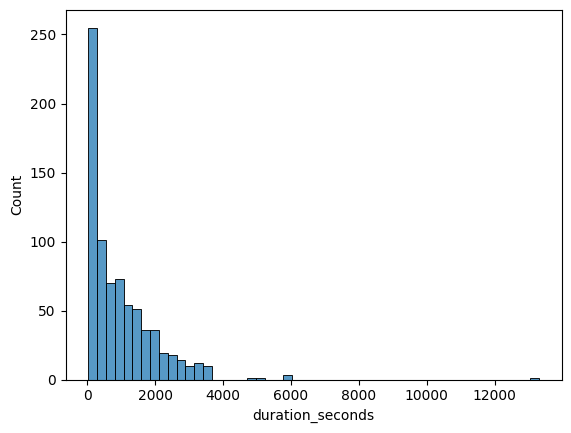

In [67]:
sns.histplot(video_dim, x="duration_seconds")

### licensed_content

In [68]:
video_dim["licensed_content"].value_counts()

licensed_content
True     699
False     66
Name: count, dtype: int64

### made_for_kids

In [69]:
video_dim["made_for_kids"].value_counts()

made_for_kids
False    763
True       2
Name: count, dtype: int64

### published_at

<Axes: xlabel='published_at', ylabel='Count'>

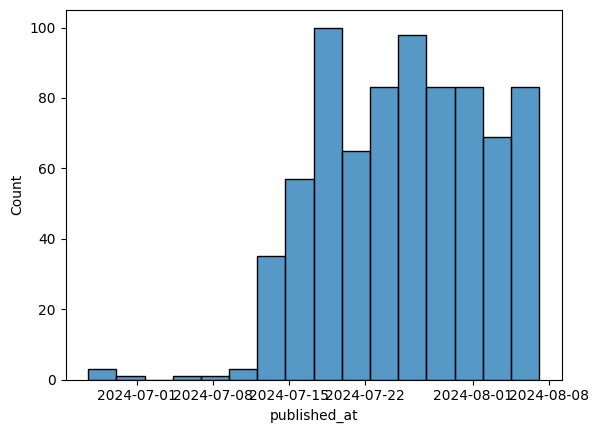

In [70]:
sns.histplot(video_dim, x="published_at")

### category_id

In [73]:
video_dim["category_id"].value_counts()

category_id
20    163
24    142
17    139
10     98
22     66
25     40
1      27
2      24
23     22
28     18
26     12
27     10
19      3
15      1
Name: count, dtype: int64

## channel_dim

In [45]:
channel_dim.shape

(581, 3)

In [46]:
channel_dim.dtypes

channel_id                  object
channel_name                object
created_datetime    datetime64[ns]
dtype: object

In [48]:
channel_dim.describe()

,created_datetime
count,581
mean,2014-06-09 12:28:27.290012672
min,2005-06-16 12:09:27
25%,2010-05-07 19:09:26
50%,2014-06-29 00:35:26
75%,2018-08-13 12:32:23
max,2024-06-29 18:33:54.191682


### channel_id

In [50]:
channel_dim["channel_id"].sample(15)

279    UCG3aWfAUJEdrGvGYwcfeefw
303    UCf4jnUGuNOyqEbRRC1kw0Uw
469    UCnGRZ9C132rHuxZdzN5NP4A
415    UCZi0oII2ua_I-fEnHdg3U2A
125    UC7ABaoK3AFxuy_i4f6xV1tA
298    UCa6vGFO9ty8v5KZJXQxdhaw
573    UC2Gu2D6VkeVYwXA8wnLvSwg
345    UCp1VWSTrt2cUBInkn4dUmDA
556    UChFur_NwVSbUozOcF_F2kMg
442    UCR9Gcq0CMm6YgTzsDxAxjOQ
166    UC-8Q-hLdECwQmaWNwXitYDw
162    UCw8_yg1camlWnYfX_0tfECw
373    UCmxURUIJXKnoC7_i1fPhs7Q
29     UCEjIjshJ8bvvCkGNk0pkYcA
305    UCAOiVaJJlH0Oduv48NN0mMA
Name: channel_id, dtype: object

In [52]:
channel_dim["channel_id"].apply(lambda x: len(x)).value_counts()

channel_id
24    581
Name: count, dtype: int64

### channel_name

In [51]:
channel_dim["channel_name"].sample(15)

103         AnthonyPadilla
244             VaatiVidya
177        That's Football
194           Darryl Mayes
434       David Alvareeezy
225                The R&A
310    Major League Soccer
231          Open Thoughts
254                 Maxedy
424            Kevin Smith
163                    CNN
92         The White House
262       JaidenAnimations
282             TorvestaRS
327              Chevrolet
Name: channel_name, dtype: object

In [53]:
channel_dim["channel_name"].apply(lambda x: len(x)).value_counts()

channel_name
10    50
12    48
13    46
11    44
14    43
15    37
8     32
7     32
17    30
16    29
9     28
5     25
19    19
6     17
18    16
3     16
4     13
20    13
24     6
21     6
22     6
26     5
23     4
25     3
31     2
27     2
34     2
2      2
38     1
28     1
50     1
37     1
36     1
Name: count, dtype: int64

### created_datetime

<Axes: xlabel='created_datetime', ylabel='Count'>

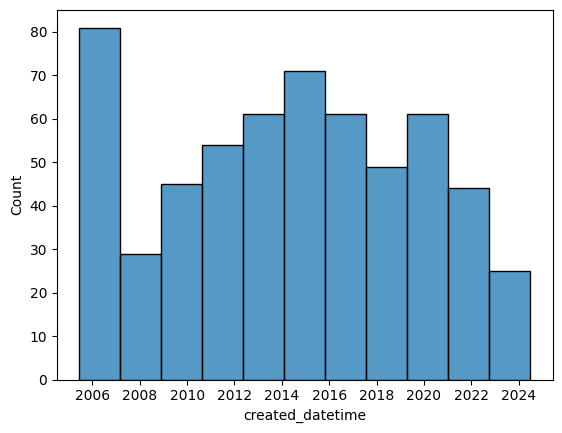

In [65]:
sns.histplot(channel_dim, x="created_datetime")

## categories_dim

In [74]:
print(categories_dim)

    category_id          category_name
0             1       Film & Animation
1             2       Autos & Vehicles
2            10                  Music
3            15         Pets & Animals
4            17                 Sports
5            18           Short Movies
6            19        Travel & Events
7            20                 Gaming
8            21          Videoblogging
9            22         People & Blogs
10           23                 Comedy
11           24          Entertainment
12           25        News & Politics
13           26          Howto & Style
14           27              Education
15           28   Science & Technology
16           29  Nonprofits & Activism
17           30                 Movies
18           31        Anime/Animation
19           32       Action/Adventure
20           33               Classics
21           34                 Comedy
22           35            Documentary
23           36                  Drama
24           37          

# Questions

## How well does a video need to do to show up on "most popular"?

In [81]:
# get the first time point in video_fact
first_times = video_fact[["video_id", "collected_at"]].groupby("video_id").min()
first_times.reset_index(inplace=True)
first_times.sample(10)


,video_id,collected_at
565,j-BKmFVCM3s,2024-08-05 00:00:06.475712
498,c1oFwTNwyqo,2024-07-20 21:00:06.211863
200,FXBWYXlOwE8,2024-07-24 15:00:05.350765
425,XE03qdGZrPc,2024-07-29 12:00:06.060721
520,dsKKW7KMURE,2024-07-21 18:00:05.102443
73,5Q3yjUKxKMk,2024-07-20 21:00:06.211863
483,aNQGRVuFteg,2024-07-22 18:00:05.555048
253,JCl3jTOUE84,2024-07-21 21:00:05.719201
562,iRxGejcTOlQ,2024-07-25 00:00:05.832583
516,dgo8HLYLMpQ,2024-08-03 21:00:05.410425


In [82]:
first_video_fact = video_fact.merge(first_times, how="inner", on=["video_id", "collected_at"])
first_video_fact.sample(10)

,collected_at,video_id,num_views,num_likes,num_comments
3,2024-07-20 21:00:06.211863,LHd447EafFY,6315163,147240,16913
736,2024-08-06 18:00:06.015978,kggCqLJnPCA,456039,11975,1413
267,2024-07-22 21:00:05.478038,d3OKTfZS5qE,198467,20413,2060
538,2024-07-31 12:00:05.690606,9S1R8UuauBM,674923,11134,577
129,2024-07-20 21:00:06.211863,j7YgKocz2W4,1137043,95248,8844
32,2024-07-20 21:00:06.211863,1W1EhV7d7xI,382300,26396,1630
33,2024-07-20 21:00:06.211863,W1goQJQNNuM,236415,10116,1113
173,2024-07-20 21:00:06.211863,bX2T-FfBkhs,3713049,22898,10446
610,2024-08-02 18:00:05.646017,yUBvP_Rj-SY,116979,16998,2269
566,2024-08-01 09:00:05.595610,b7FNmUjR-bo,1216440,17746,1732


In [85]:
first_times.shape, first_video_fact.shape

((765, 2), (765, 5))

In [86]:
# join with attributes in video_dim
first_video_all = first_video_fact.merge(video_dim, how="inner", on="video_id")
first_video_all.sample(10)

,collected_at,video_id,num_views,num_likes,num_comments,channel_id,video_title,video_description,num_tags,duration_seconds,licensed_content,made_for_kids,published_at,category_id
333,2024-07-25 00:00:05.832583,iRxGejcTOlQ,229258,44200,1297,UCsEukrAd64fqA7FjwkmZ_Dw,Stray Kids Reply to Fans Online | Actually Me,K-pop sensations Stray Kids join GQ in ‘Actual...,33,576,True,False,2024-07-24 16:00:13,24
277,2024-07-23 15:00:05.987233,MShEDzXNF_Q,286961,9859,1373,UCQMELFlXQL38KPm8kM-4Adg,Exploring the Last Dodge Charger Police Pursui...,"In this exciting episode of Jay Leno's Garage,...",35,1627,True,False,2024-07-22 16:00:08,2
191,2024-07-20 21:00:06.211863,xywWrzLFq2E,2212269,83904,4419,UCJbYdyufHR-cxOuY96KIoqA,AMP BATTLE BOTS,Get tickets to see @BattleBots in Las Vegas 💥 ...,15,2010,True,False,2024-07-12 20:18:11,24
625,2024-08-03 00:00:06.155912,6w97dXvadgs,622240,33288,3127,UCIVSqoHCUN1XdEpiVItxfoQ,I Collected EVERY NEW WOLF in Minecraft Hardcore,I Trapped Every New Wolf Variant in 1.21 Hardc...,20,1723,True,False,2024-08-02 12:00:11,20
706,2024-08-05 15:00:05.390417,XZgJm6sTGIE,117294,1227,238,UC4XO5MevdtVYSwUCBNNULVA,Paris 2024 | Noah Lyles reflects on victory af...,Watch the Paris 2024 Olympics | July 26 - Augu...,8,121,True,False,2024-08-04 21:47:48,17
66,2024-07-20 21:00:06.211863,w3HZ3ior4_s,778265,113919,0,UCE6l2NHQkpgF_P96isfOu4Q,Slow Dance (feat. Sofia Carson),Provided to YouTube by BIGHIT MUSIC\n\nSlow Da...,5,189,True,False,2024-07-19 04:00:39,10
21,2024-07-20 21:00:06.211863,GspacNMHSbM,1884390,65344,7935,UClOf1XXinvZsy4wKPAkro2A,Juno | New Hero Gameplay Trailer | Overwatch 2,"3, 2, 1, blast off with our newest Support her...",2,117,True,False,2024-07-18 16:00:22,20
335,2024-07-25 12:00:05.385740,vwBvmX3DNbw,855359,79821,5087,UCzfScS0MkYf1EHTPFCYt79Q,I bought Tara her Dream Car!,Try Opera browser FOR FREE here https://opr.as...,22,1440,True,False,2024-07-24 19:57:48,24
469,2024-07-28 21:00:05.775313,VPSm9gJkPxU,381242,31129,4143,UC6107grRI4m0o2-emgoDnAA,Nature's Incredible ROTATING MOTOR (It’s Elect...,Thank you for considering support for Smarter ...,31,1777,True,False,2024-07-28 14:00:19,28
500,2024-07-29 18:00:06.152434,J6Hhtqxvn9w,379555,7050,1150,UC34Qdd5Z5KN30A8aJ2eIMPA,HOUSE OF THE DRAGON Season 2 Episode 7 Breakdo...,In this video we take a deep dive into season ...,18,1398,True,False,2024-07-29 02:03:00,1


In [97]:
# get time difference between time published and time collected
first_video_all["hours_since_published"] = (first_video_all["published_at"] - first_video_all["collected_at"])/pd.Timedelta("-1h")
first_video_all["hours_since_published"]

0      31.058670
1      25.833948
2      41.001726
3      42.033670
4      22.533114
         ...    
760    21.017496
761    17.670552
762    15.999996
763    14.858329
764    12.644996
Name: hours_since_published, Length: 765, dtype: float64

In [108]:
summary_stats = first_video_all.describe()
numeric_cols = summary_stats.columns
summary_stats

,collected_at,num_views,num_likes,num_comments,num_tags,duration_seconds,published_at,category_id,time_since_published,hours_since_published
count,765,7.650000e+02,7.650000e+02,765.000000,765.000000,765.000000,765,765.000000,765.000000,765.000000
mean,2024-07-27 08:35:37.609999616,1.470145e+06,7.334101e+04,5125.045752,16.030065,963.409150,2024-07-25 16:47:18.958169600,18.564706,39.805181,39.805181
min,2024-07-20 21:00:06.211863,3.034000e+04,0.000000e+00,0.000000,0.000000,22.000000,2024-06-26 12:22:40,1.000000,1.984876,1.984876
25%,2024-07-20 21:00:06.211863040,2.245090e+05,8.260000e+03,742.000000,4.000000,203.000000,2024-07-19 15:28:04,17.000000,11.986835,11.986835
50%,2024-07-26 15:00:06.133091072,4.398920e+05,1.790200e+04,1615.000000,15.000000,635.000000,2024-07-25 21:00:07,20.000000,20.220552,20.220552
75%,2024-08-01 15:00:05.894264064,9.501960e+05,4.578500e+04,3502.000000,25.000000,1406.000000,2024-07-31 17:00:24,24.000000,30.999836,30.999836
max,2024-08-07 15:00:05.985525,1.595597e+08,7.392365e+06,337068.000000,64.000000,13311.000000,2024-08-07 02:21:24,28.000000,584.623948,584.623948
std,NaN,7.540386e+06,4.016360e+05,21391.230705,13.076012,1045.677287,NaN,6.555647,59.537830,59.537830


- The least viewed video had 3k views and the most viewed had 159 million before it was "most popular"
- Some "most popular" videos have no likes, no comments, and/or no tags.
- Videos can be as few as 22 seconds long or as many as 13000 seconds long (3.6 hrs)
- 75% of videos that show up on most popular have been out for less than 30 hours.

In [114]:
melted = first_video_all[numeric_cols].melt(var_name="column")
melted.sample(5)


,column,value
4227,duration_seconds,194
4696,published_at,2024-07-16 16:00:08
254,collected_at,2024-07-22 12:00:05.746991
7392,hours_since_published,4.985708
969,num_views,585757


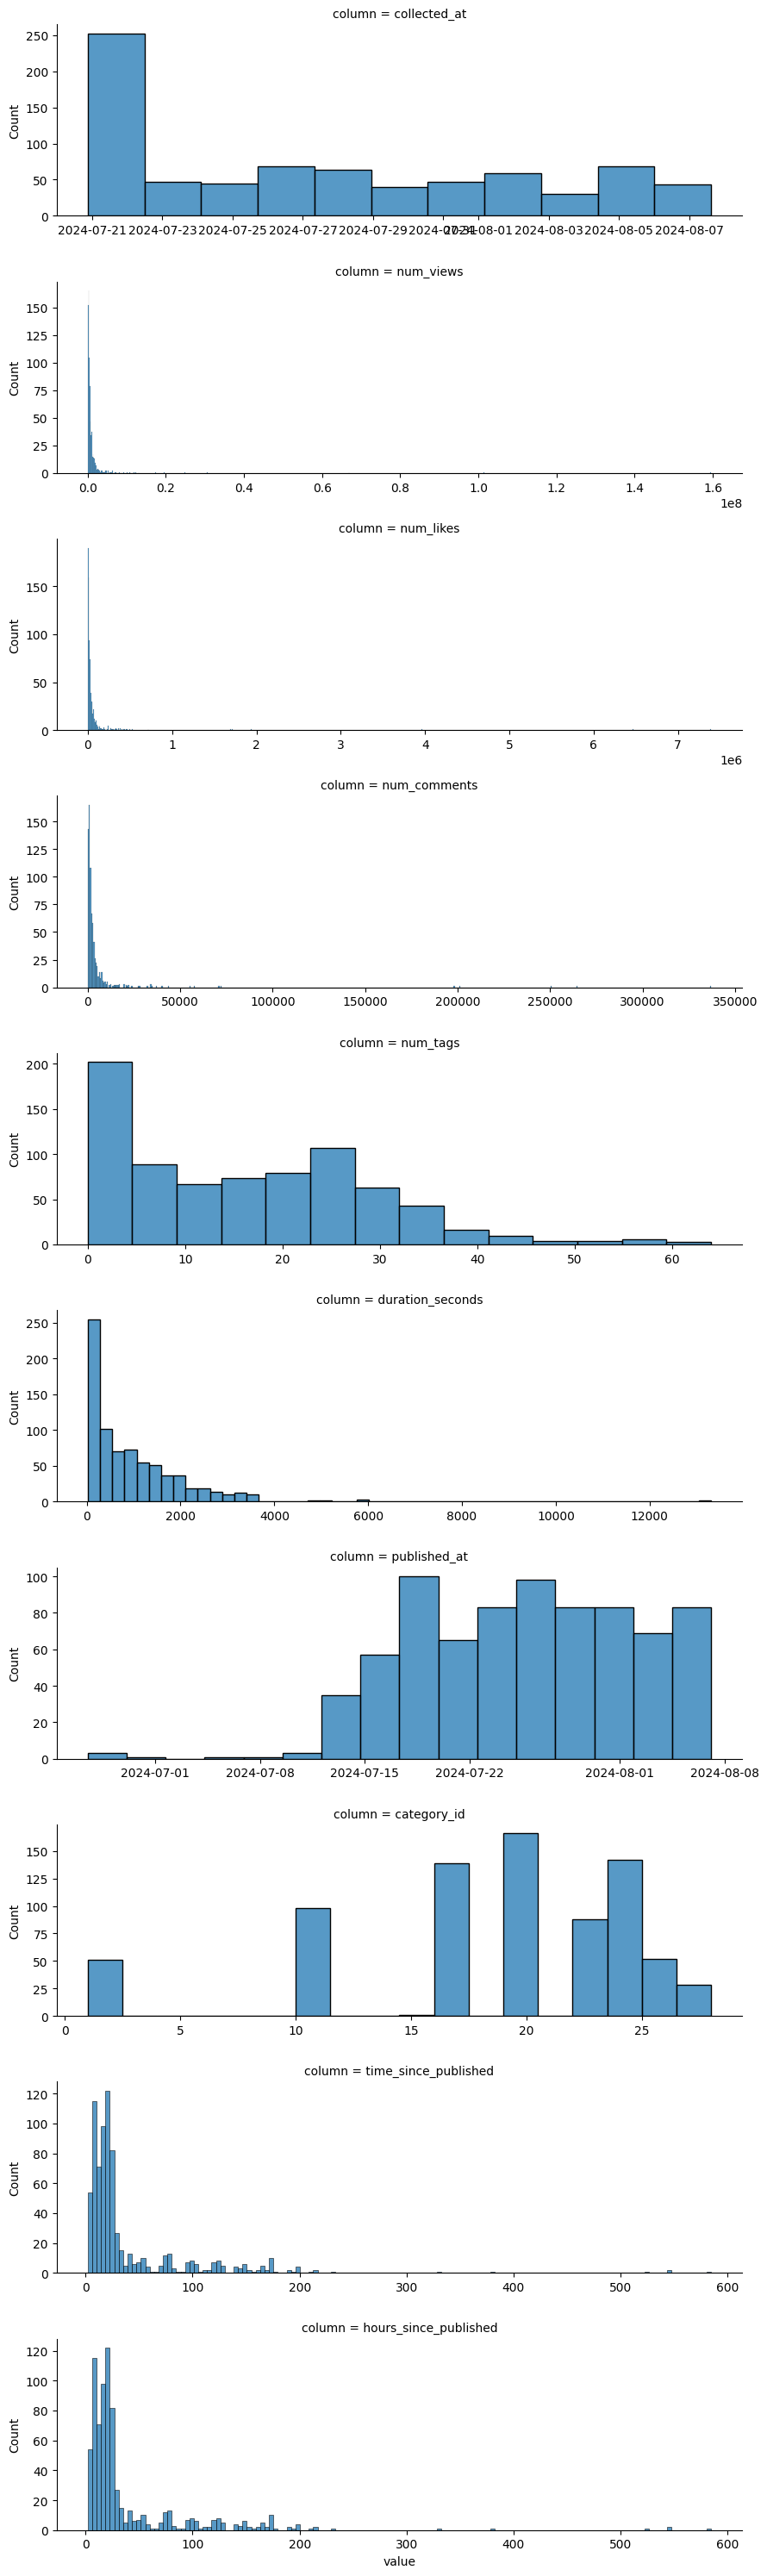

In [115]:
g = sns.FacetGrid(melted, row="column", sharey=False, sharex=False, aspect=3)
g.map_dataframe(sns.histplot, "value")

In [116]:
first_video_all.columns

Index(['collected_at', 'video_id', 'num_views', 'num_likes', 'num_comments',
       'channel_id', 'video_title', 'video_description', 'num_tags',
       'duration_seconds', 'licensed_content', 'made_for_kids', 'published_at',
       'category_id', 'time_since_published', 'hours_since_published'],
      dtype='object')

In [119]:
# how many videos have 0 likes, comments, or tags?
no_comments = first_video_all.loc[first_video_all["num_comments"] == 0]
no_comments.shape[0]/first_video_all.shape[0] * 100

2.2222222222222223

2% of videos have comments disabled

In [120]:
no_tags = first_video_all.loc[first_video_all["num_tags"] == 0]
no_tags.shape[0]/first_video_all.shape[0] * 100

17.124183006535947

17% of videos have no tags

In [121]:
no_likes = first_video_all.loc[first_video_all["num_likes"] == 0]
no_likes.shape[0]/first_video_all.shape[0] * 100

0.39215686274509803

.4% of videos have likes hidden

In [122]:
first_video_all.columns

Index(['collected_at', 'video_id', 'num_views', 'num_likes', 'num_comments',
       'channel_id', 'video_title', 'video_description', 'num_tags',
       'duration_seconds', 'licensed_content', 'made_for_kids', 'published_at',
       'category_id', 'time_since_published', 'hours_since_published'],
      dtype='object')

In [124]:
corr_cols = ['num_views', 'num_likes', 'num_comments', 'num_tags', 'duration_seconds', 'licensed_content', 'made_for_kids', 'hours_since_published']

<Axes: >

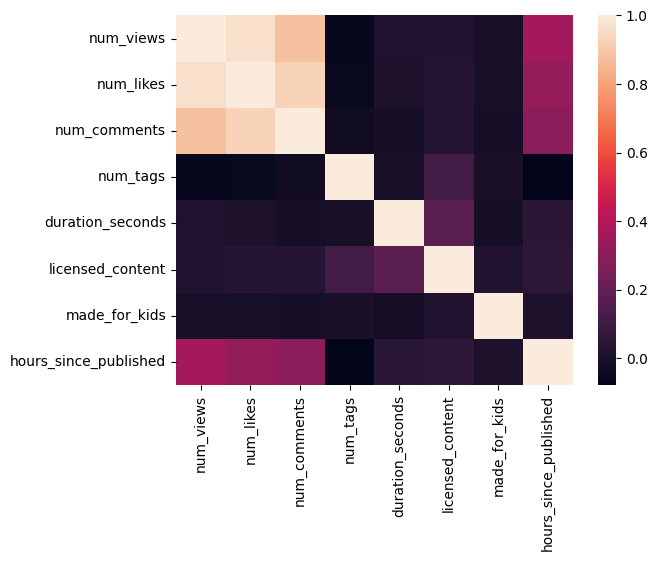

In [125]:
sns.heatmap(first_video_all[corr_cols].corr())

Views, likes, and comments are correlated, and there's a slight correlation between the video being out for longer and having more likes, views, and comments. Not surprising. The other variables seem to have no effect on views.

### Conclusion
There doesn't seem to be any specific level of performance for videos to show up on most popular. It's hard to even answer this question because I don't have any information on what the videos' stats looked like before they were on most popular.

## How much do views grow after one day and one week?

The views column is hierarchical; there are many time series embedded within this one table. In order to compare the time series, I have to standardize the values to all be within a specific range. 

In [ ]:
# get ids for videos where I have >=1 day of data

In [ ]:
# get ids for videos where I have >=1 week of data

In [126]:
video_fact.columns

Index(['collected_at', 'video_id', 'num_views', 'num_likes', 'num_comments'], dtype='object')

In [128]:
video_fact.sample(45)

,collected_at,video_id,num_views,num_likes,num_comments
28550,2024-07-30 18:00:05.429448,u904orAD6O4,523200,17783,553
56376,2024-08-05 09:00:05.255966,kkuCu6ZEgNI,193057,1471,327
21343,2024-07-28 21:00:05.775313,HZbav4ym_NA,101349,3475,738
2846,2024-07-22 09:00:05.704148,9TTEWjWsjZ4,232864,19803,1050
39556,2024-08-02 03:00:05.437633,kMw-S2Rajn0,392386,53099,3543
36440,2024-08-01 12:00:05.299340,eqnk9LopuOQ,707026,8765,711
61895,2024-08-06 09:00:05.982302,93nFkNBbgaI,1162457,29006,4525
61379,2024-08-06 09:00:05.982302,LHd447EafFY,9956476,206374,26047
29273,2024-07-30 21:00:06.064454,Aj097_OV8w4,447369,8760,870
26947,2024-07-30 09:00:05.348955,W1goQJQNNuM,726355,20747,2835


## What types of videos perform the best?

## What types of channels perform the best?

## Is there a best date or time of day to upload?